# Noise (Dense probe)

author: steeve.laquitaine@epfl.ch

**Method**:  
* calculated from first 10 minutes for speed
* minimum mean absolute deviation over trace segments of 1 seconds


## Setup 


1. compute noise data: src/pipes/validation/noise/mpi_dense_full.py

2. activate spikeinter..

In [3]:
# import libs
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import multiprocessing
import torch
import spikeinterface as si
import seaborn as sns

# move to PROJECT PATH
PROJ_PATH = "/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/spikebias/"
os.chdir(PROJ_PATH)

from src.nodes.utils import get_config, get_stats_config, standardize_layers
from src.nodes.validation import noise

# SETUP PARAMETERS
RND_SEED = 0                # random seed
SF_V = 20000          # sampling frequency
SF_S = 20000        # sampling frequency
WIND_END = 3700             # last segment to calculate mad

# vivo ----------
# probe 1 
data_conf_hv_p1, _ = get_config("vivo_horvath", "probe_1").values() 
RAW_PATH_hv_p1 = data_conf_hv_p1["raw"]
PREP_PATH_hv_p1 = data_conf_hv_p1["preprocessing"]["full"]["output"]["trace_file_path"]
NOISE_PATH_hv_p1 = data_conf_hv_p1["analyses"]["traces"]["noise"]

# probe 2
data_conf_hv_p2, _ = get_config("vivo_horvath", "probe_2").values() 
RAW_PATH_hv_p2 = data_conf_hv_p2["raw"]
PREP_PATH_hv_p2 = data_conf_hv_p2["preprocessing"]["full"]["output"]["trace_file_path"]
NOISE_PATH_hv_p2 = data_conf_hv_p2["analyses"]["traces"]["noise"]

# probe 3
data_conf_hv_p3, _ = get_config("vivo_horvath", "probe_3").values() 
PREP_PATH_hv_p3 = data_conf_hv_p3["preprocessing"]["full"]["output"]["trace_file_path"]
NOISE_PATH_hv_p3 = data_conf_hv_p3["analyses"]["traces"]["noise"]

# silico ----------
# probe 1
data_conf_hs_p1, param_conf_hs_p1 = get_config("dense_spont", "probe_1").values()
PREP_PATH_hs_p1 = data_conf_hs_p1["preprocessing"]["full"]["output"]["trace_file_path"]
NOISE_PATH_hs_p1 = data_conf_hs_p1["analyses"]["traces"]["noise"]

# probe 2
data_conf_hs_p2, param_conf_hs_p2 = get_config("dense_spont", "probe_2").values()
PREP_PATH_hs_p2 = data_conf_hs_p2["preprocessing"]["full"]["output"]["trace_file_path"]
NOISE_PATH_hs_p2 = data_conf_hs_p2["analyses"]["traces"]["noise"]

# probe 3
data_conf_hs_p3, param_conf_hs_p3 = get_config("dense_spont", "probe_3").values()
PREP_PATH_hs_p3 = data_conf_hs_p3["preprocessing"]["full"]["output"]["trace_file_path"]
NOISE_PATH_hs_p3 = data_conf_hs_p3["analyses"]["traces"]["noise"]

# pipeline parameters
SAVE_FIG = False
SAVE_TEMP_DATA = False
LOAD_TEMP_DATA = True

PLOT_DATA_PATH = get_stats_config()["fig2p_data_noise_dense"]


# FIGURE SETTINGS
FIG_SIZE = (1.8, 1.4)
COLOR_HV = [0.3, 0.3, 0.3]
COLOR_HS = np.array([26, 152, 80]) / 255 # green

cl = dict()
cl["COLOR_HV"] = "k" # black
cl["COLOR_HS"] = np.array([26, 152, 80]) / 255 # green

# axes
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 6  # 5-7 with Nature neuroscience as reference
plt.rcParams["lines.linewidth"] = 0.5
plt.rcParams["axes.linewidth"] = 0.5 #1
plt.rcParams["axes.spines.top"] = False
plt.rcParams["xtick.major.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["xtick.minor.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["ytick.major.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["ytick.minor.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["xtick.major.size"] = 3.5 * 1.1
plt.rcParams["xtick.minor.size"] = 2 * 1.1
plt.rcParams["ytick.major.size"] = 3.5 * 1.1
plt.rcParams["ytick.minor.size"] = 2 * 1.1
# legend
savefig_cfg = {"transparent":True, "dpi":300}
legend_cfg = {"frameon": False, "handletextpad": 0.1}
tight_layout_cfg = {"pad": 0.5}
LG_FRAMEON = False              # no legend frame

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2024-12-09 10:09:15,110 - root - utils.py - get_config - INFO - Reading experiment config.
2024-12-09 10:09:15,148 - root - utils.py - get_config - INFO - Reading experiment config. - done
2024-12-09 10:09:15,150 - root - utils.py - get_config - INFO - Reading experiment config.
2024-12-09 10:09:15,190 - root - utils.py - get_config - INFO - Reading experiment config. - done
2024-12-09 10:09:15,191 - root - utils.py - get_config - INFO - Reading experiment config.
2024-12-09 10:09:15,225 - root - utils.py - get_config - INFO - Reading experiment config. - done
2024-12-09 10:09:15,227 - root - utils.py - get_config - INFO - Reading experiment config.
2024-12-09 10:09:15,316 - root - utils.py - get_config - INFO - Reading experiment config. - done
2024-12-09 10:09:15,318 - root - utils.py - get_config - INFO - Reading experiment config.
2024-12-09 10:09:15,498 - root - utils.py - get_config - INFO - R

### Specs

In [6]:
print("available cpus:", multiprocessing.cpu_count())
print("available gpus:", torch.cuda.is_available())

available cpus: 72
available gpus: True


### (8m)Load noise data

* for 10 minutes of recording (45 mins)
* pytorch implementation (8min) of mean absolute deviation is 7 times faster than pandas (45m).

In [4]:
# load
plot_data_v1 = pd.read_csv(NOISE_PATH_hv_p1)
plot_data_v2 = pd.read_csv(NOISE_PATH_hv_p2)
plot_data_v3 = pd.read_csv(NOISE_PATH_hv_p3)

plot_data_s1 = pd.read_csv(NOISE_PATH_hs_p1)
plot_data_s2 = pd.read_csv(NOISE_PATH_hs_p2)
plot_data_s3 = pd.read_csv(NOISE_PATH_hs_p3)

# select relevant data
plot_data_s1 = plot_data_s1[["noise", "layer", "experiment"]]
plot_data_s2 = plot_data_s2[["noise", "layer", "experiment"]]
plot_data_s3 = plot_data_s3[["noise", "layer", "experiment"]]

# select L4 and L5 from probe 2
plot_data_v2 = plot_data_v2[
    (plot_data_v2["layer"] == "L4") | (plot_data_v2["layer"] == "L5")
]

# select L4 and L5 from probe 2
plot_data_s2 = plot_data_s2[np.isin(plot_data_s2["layer"], ["L4", "L5"])]

# unit-test
assert plot_data_v1["layer"].unique().tolist() == ["L1", "L2_3"], "wrong layers"
assert plot_data_v2["layer"].unique().tolist() == ["L4", "L5"], "wrong layers"
assert plot_data_v3["layer"].unique().tolist() == ["L6"], "wrong layers"
assert plot_data_s1["layer"].unique().tolist() == ["L1", "L2_3"], "wrong layers"
assert plot_data_s2["layer"].unique().tolist() == ["L4", "L5"], "wrong layers"
assert plot_data_s3["layer"].unique().tolist() == ["L6"], "wrong layer"

# stack
plot_data = pd.concat(
    [
        plot_data_v1,
        plot_data_v2,
        plot_data_v3,
        plot_data_s1,
        plot_data_s2,
        plot_data_s3,
    ],
    ignore_index=True,
)

# standardize names
plot_data["experiment"][plot_data["experiment"] == "vivo"] = "Dense probe (Horvath)"
plot_data["experiment"][
    plot_data["experiment"] == "silico"
] = "Dense probe (biophy. spont.)"

# standardize layer 2/3
plot_data["layer"][plot_data["layer"] == "L2"] = "L2/3"
plot_data["layer"][plot_data["layer"] == "L3"] = "L2/3"
plot_data["layer"][plot_data["layer"] == "L2_3"] = "L2/3"

In [4]:
# save plot and statistics data
if SAVE_TEMP_DATA:
    plot_data.to_parquet(PLOT_DATA_PATH)
    print("Saved here:", PLOT_DATA_PATH)
elif LOAD_TEMP_DATA:
    plot_data = pd.read_parquet(PLOT_DATA_PATH)

## Layers per depth (model vs. vivo) 

In [5]:
def print_layer_set(exp, cfg):
    print(
        exp,
        np.unique(
            si.load_extractor(cfg["probe_wiring"]["output"]).get_property("layers")
        ),
    )

In [16]:
# print_layer_set("hv1:", data_conf_hv_p1)
# print_layer_set("hs1:", data_conf_hs_p1)

# print_layer_set("hv2:", data_conf_hv_p2)
# print_layer_set("hs2:", data_conf_hs_p2)

# print_layer_set("hv3:", data_conf_hv_p3)
# print_layer_set("hs3:", data_conf_hs_p3)

### Plot

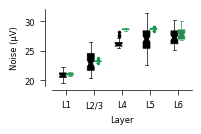

In [6]:
FIG_SIZE = (1.8, 1)

fig, ax = plt.subplots(1, 1, figsize=FIG_SIZE)

ax = sns.boxplot(
    ax=ax,
    data=plot_data,
    x="layer",
    y="noise",
    hue="experiment",
    notch=True,
    hue_order=["Dense probe (Horvath)", "Dense probe (biophy. spont.)"],
    palette=[cl["COLOR_HV"], cl["COLOR_HS"]],
    width=0.5,
    linewidth=0.5,
    flierprops={
        "marker": ".",
        "markersize": 3,
    },
)
# axes
ax.spines[["top", "right"]].set_visible(False)
ax.legend("", frameon=False)

# disconnect axes (R style)
ax.spines["bottom"].set_position(("axes", -0.05))
ax.yaxis.set_ticks_position("left")
ax.spines["left"].set_position(("axes", -0.05))

# labels
ax.set_ylabel("Noise (\u03bcV)")
ax.set_xlabel("Layer")

# customize the boxplot
p = 0
for box in ax.patches:
    if box.__class__.__name__ == "PathPatch":
        # a list item for each layer group
        if p in [0, 1, 2, 3, 4]:
            box.set_edgecolor(cl["COLOR_HV"])
            # Each box has 6 associated Line2D objects
            # (to make the whiskers, fliers, etc.)
            # Loop over them here, and use the same colour
            # as above
            # group 1 (HV)
            for k in range(6 * p, 6 * (p + 1)):
                ax.lines[k].set_color(cl["COLOR_HV"])  # box
                ax.lines[k].set_mfc(cl["COLOR_HV"])  # whisker
                ax.lines[k].set_mec(cl["COLOR_HV"])  # fliers
            p += 1
        elif p in [5, 6, 7, 8, 9]:
            # group 2 (HS)
            box.set_edgecolor(cl["COLOR_HS"])
            for k in range(6 * p, 6 * (p + 1)):
                ax.lines[k].set_color(cl["COLOR_HS"])
                ax.lines[k].set_mfc(cl["COLOR_HS"])
                ax.lines[k].set_mec(cl["COLOR_HS"])
            p += 1

# save figures
if SAVE_FIG:
    plt.savefig(    
        "figures/0_validation/3_noise/fig2P/fig2P_noise_denser.svg",
        bbox_inches="tight",
        **savefig_cfg
    )

## Hyp. testing

### H0: Does Horvath noise change across layers? YES

* L1 vs. L2/3 differs: (p=9e-4)
* L2/3 vs. L4 differs: (p=1e-6)
* L4 vs. L5 is same: (p=0.7)
* L5 vs. L6 differs: (p=0.009)

In [7]:
def ci95(data):
    return 1.96 * np.nanstd(data) / np.sqrt(np.sum(~np.isnan(data)))

def get_medians_and_ci95(plot_data, exp, feature: str):
    layers = ["L1", "L2/3", "L4", "L5", "L6"]
    stats = ""
    for layer in layers:
        feature_data = plot_data[(plot_data.experiment==exp) & (plot_data.layer==layer)][feature]
        stats += f"{feature_data.median()} $\pm$ {np.round(ci95(feature_data),3)}, "
    print(stats)

In [6]:
# perform Dunn's posthoc test using a holm-sidak correction for the p-values
# to identify the layer amplitudes that significantly deviate from others
noise.get_kk(plot_data, "Dense probe (Horvath)")
display(noise.get_posthoc_dunn_holm_sidak(plot_data, "Dense probe (Horvath)"))
get_medians_and_ci95(plot_data, "Dense probe (Horvath)", "noise")

H=175.52139986119232, p=6.82704885032333e-37
N_L1 = 36 sites
N_L23 = 60 sites
N_L4 = 20 sites
N_L5 = 88 sites
N_L6 = 68 sites


,L1,L2/3,L4,L5,L6
L1,1.000000e+00,1.147452e-02,5.984886e-09,9.654362e-22,2.639376e-25
L2/3,1.147452e-02,1.000000e+00,1.549393e-04,3.314816e-14,1.083038e-17
L4,5.984886e-09,1.549393e-04,1.000000e+00,3.410051e-01,1.627195e-01
L5,9.654362e-22,3.314816e-14,3.410051e-01,1.000000e+00,2.353189e-01
L6,2.639376e-25,1.083038e-17,1.627195e-01,2.353189e-01,1.000000e+00


20.842678 $\pm$ 0.2, 22.867880999999997 $\pm$ 0.4, 25.9910255 $\pm$ 0.3, 27.0063 $\pm$ 0.4, 27.228057 $\pm$ 0.3, 


### H1: Does spont model noise change across layer? YES.

In [ ]:
noise.get_kk(plot_data, "Dense probe (biophy. spont.)")
noise.get_posthoc_dunn_holm_sidak(plot_data, "Dense probe (biophy. spont.)")
get_medians_and_ci95(plot_data, "Dense probe (biophy. spont.)", "noise")

H=232.14160227236243, p=4.566044574016996e-49
N_L1 = 37 sites
N_L23 = 64 sites
N_L4 = 32 sites
N_L5 = 88 sites
N_L6 = 76 sites
20.976402 $\pm$ 0.059, 23.2371735 $\pm$ 0.034, 28.6790785 $\pm$ 0.039, 28.7144375 $\pm$ 0.025, 27.722406499999998 $\pm$ 0.199, 


## Are Models and in vivo data the same?

In [11]:
from scipy.stats import kruskal
import scikit_posthocs as sp


def count_sites(df, exp, layer):
    return len(df[(df["experiment"] == exp) & (df["layer"] == layer)])


def get_noise(df, exp, layer):
    return df[(df["experiment"] == exp) & (df["layer"] == layer)]["noise"].values


def get_kk_compare_exps(df, layer):
    """kruskall wallis test
    """
    h, p = kruskal(
        get_noise(df, "Dense probe (Horvath)", layer),
        get_noise(df, "Dense probe (biophy. spont.)", layer),
    )
    print(f"H={h}, p={p}")
    print(f"""N_H = {count_sites(df, "Dense probe (Horvath)", layer)} sites""")
    print(f"""N_DS = {count_sites(df, "Dense probe (biophy. spont.)", layer)} sites""")
    
    
def get_posthoc_dunn_holm_sidak_compare_exps(plot_data, layer):
    """posthoc test after kruskall wallis with Dunn and holm_sidak
    multiple comparison correction of p-values

    Args:
        plot_data (_type_): _description_
        exp (_type_): _description_

    Returns:
        _type_: _description_
    """
    data = [
        get_noise(plot_data, "Dense probe (Horvath)", layer),
        get_noise(plot_data, "Dense probe (biophy. spont.)", layer),
    ]
    # holm sidak method has more power than Bonferroni which is more conservative
    # Non-significance can indicate subtle differences, power issues, samll sample size,
    # or the balancing be due to how the Holm-Sidak correction controls Type I errors
    # while retaining power.
    # we can still look at the p-values to identify trends.
    df = sp.posthoc_dunn(data, p_adjust="holm-sidak")
    df.columns = ["Dense probe (Horvath)", "Dense probe (biophy. spont.)"]
    df.index = ["Dense probe (Horvath)", "Dense probe (biophy. spont.)"]
    return df


def get_posthoc_dunn_holm_sidak_compare_exps_l5(plot_data, layer):
    """posthoc test after kruskall wallis with Dunn and holm_sidak
    multiple comparison correction of p-values

    Args:
        plot_data (_type_): _description_
        exp (_type_): _description_

    Returns:
        _type_: _description_
    """
    data = [
        get_noise(plot_data, "Dense probe (Horvath)", layer),
        get_noise(plot_data, "Dense probe (biophy. spont.)", layer),
    ]
    # holm sidak method has more power than Bonferroni which is more conservative
    # Non-significance can indicate subtle differences, power issues, samll sample size,
    # or the balancing be due to how the Holm-Sidak correction controls Type I errors
    # while retaining power.
    # we can still look at the p-values to identify trends.
    df = sp.posthoc_dunn(data, p_adjust="holm-sidak")
    df.columns = ["Dense probe (Horvath)", "Dense probe (biophy. spont.)"]
    df.index = ["Dense probe (Horvath)", "Dense probe (biophy. spont.)"]
    return df

In [12]:
print("------LAYER 1:------\n")

# kruskall-wallis
# perform Dunn's posthoc test using a holm-sidak correction for the p-values
# to identify the layer amplitudes that significantly deviate from others
get_kk_compare_exps(plot_data, "L1")
display(get_posthoc_dunn_holm_sidak_compare_exps(plot_data, "L1"))


print("\n------LAYER 2/3:------\n")

get_kk_compare_exps(plot_data, "L2/3")
display(get_posthoc_dunn_holm_sidak_compare_exps(plot_data, "L2/3"))

print("\n------LAYER 4:------\n")

get_kk_compare_exps(plot_data, "L4")
display(get_posthoc_dunn_holm_sidak_compare_exps(plot_data, "L4"))

print("\n------LAYER 5:------\n")

get_kk_compare_exps(plot_data, "L5")
display(get_posthoc_dunn_holm_sidak_compare_exps_l5(plot_data, "L5"))

print("\n------LAYER 6:------\n")

get_kk_compare_exps(plot_data, "L6")
display(get_posthoc_dunn_holm_sidak_compare_exps(plot_data, "L6"))

------LAYER 1:------

H=3.274409544679827, p=0.070368243893953
N_H = 36 sites
N_DS = 37 sites


,Dense probe (Horvath),Dense probe (biophy. spont.)
Dense probe (Horvath),1.000000,0.070368
Dense probe (biophy. spont.),0.070368,1.000000



------LAYER 2/3:------

H=3.150624999999934, p=0.07589788718738133
N_H = 60 sites
N_DS = 64 sites


,Dense probe (Horvath),Dense probe (biophy. spont.)
Dense probe (Horvath),1.000000,0.075898
Dense probe (biophy. spont.),0.075898,1.000000



------LAYER 4:------

H=36.226415094339615, p=1.7567319179177604e-09
N_H = 20 sites
N_DS = 32 sites


,Dense probe (Horvath),Dense probe (biophy. spont.)
Dense probe (Horvath),1.000000e+00,1.756732e-09
Dense probe (biophy. spont.),1.756732e-09,1.000000e+00



------LAYER 5:------

H=52.55025213615352, p=4.1937890383532494e-13
N_H = 88 sites
N_DS = 88 sites


,Dense probe (Horvath),Dense probe (biophy. spont.)
Dense probe (Horvath),1.000000e+00,4.193789e-13
Dense probe (biophy. spont.),4.193789e-13,1.000000e+00



------LAYER 6:------

H=5.900218853421563, p=0.015139003557657727
N_H = 68 sites
N_DS = 76 sites


,Dense probe (Horvath),Dense probe (biophy. spont.)
Dense probe (Horvath),1.000000,0.015139
Dense probe (biophy. spont.),0.015139,1.000000


### H1: Model and data noise are the same - no

In [8]:
print("\nlayer 1\n")
noise.get_mwu(plot_data, "Dense probe (Horvath)", "Dense probe (biophy. spont.)", "L1")

print("\nlayer 2/3\n")
noise.get_mwu(
    plot_data, "Dense probe (Horvath)", "Dense probe (biophy. spont.)", "L2/3"
)

print("\nlayer 4\n")
noise.get_mwu(plot_data, "Dense probe (Horvath)", "Dense probe (biophy. spont.)", "L4")

print("\nlayer 5\n")
noise.get_mwu(plot_data, "Dense probe (Horvath)", "Dense probe (biophy. spont.)", "L5")

print("\nlayer 6\n")
noise.get_mwu(plot_data, "Dense probe (Horvath)", "Dense probe (biophy. spont.)", "L6")


layer 1

1 vs. 2, z=502.0, p=0.07107643334982655, N_1=36, N_2=37

layer 2/3

1 vs. 2, z=1565.0, p=0.07626045115090274, N_1=60, N_2=64

layer 4

1 vs. 2, z=0.0, p=1.5873692659979667e-14, N_1=20, N_2=32

layer 5

1 vs. 2, z=1422.0, p=2.5110639219655938e-14, N_1=88, N_2=88

layer 6

1 vs. 2, z=1977.0, p=0.014909479384037909, N_1=68, N_2=76
